In [2]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [4]:
artm.version()

'0.9.0'

In [123]:
name_dataset = 'sport'

### load data

In [124]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(60849, 7)
CPU times: user 5.59 s, sys: 38.5 ms, total: 5.63 s
Wall time: 5.04 s


In [125]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,"Лейла Али, дочь известного боксера-тяжеловеса ...",Спорт
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",В субботу 9 октября на Большой спортивной арен...,Спорт


### preprocess

* get dates

In [126]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 130 ms, sys: 3.91 ms, total: 134 ms
Wall time: 118 ms


<unknown>:2: DeprecationWarning: invalid escape sequence \d


* clean text

In [127]:
import preprocessing_tools as pr

In [128]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 8.62 s, sys: 0 ns, total: 8.62 s
Wall time: 7.71 s


In [129]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,лейла али дочь известного боксератяжеловеса му...,Спорт,"[(1999, 10, 08)]",1999,10
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",в субботу октября на большой спортивной арене...,Спорт,"[(1999, 10, 09)]",1999,10


* cleanedNames

In [130]:
from cleanedNames import KeyProc
cn = KeyProc()

In [131]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 13s


* lemmatization

In [132]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 13s


* add docID

In [133]:
df['docID'] = list(range(df.shape[0]))

In [134]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[лейла, али, дочь, известный, боксератяжеловес..."
1,1,1999,10,"[суббота, октябрь, большой, спортивный, арен, ..."


In [135]:
print(df.shape)
df.isnull().sum()

(60849, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [139]:
df.year.min()

1999

## model

* prepare

In [140]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 547 ms, sys: 74.1 ms, total: 621 ms
Wall time: 612 ms


In [141]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [143]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/sport", num_batches=61)
CPU times: user 20 s, sys: 0 ns, total: 20 s
Wall time: 3.19 s


In [144]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [145]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=8e611c9c-026d-4710-8a05-5dcad298c537, num_entries=21820)

In [146]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [281]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.14394648373126984
	SparsityPhiScore: 0.3168881833553314
	PerplexityScore: 3844.85546875
	time: 0:00:26.727798
#topic 3.........
	SparsityThetaScore: 0.3128618896007538
	SparsityPhiScore: 0.4279407262802124
	PerplexityScore: 3266.755126953125
	time: 0:00:27.963084
#topic 4.........
	SparsityThetaScore: 0.47226741909980774
	SparsityPhiScore: 0.5142186284065247
	PerplexityScore: 2883.92431640625
	time: 0:00:28.637152
#topic 5.........
	SparsityThetaScore: 0.5518217086791992
	SparsityPhiScore: 0.5772044062614441
	PerplexityScore: 2650.1103515625
	time: 0:00:29.600335
#topic 6.........
	SparsityThetaScore: 0.5685713887214661
	SparsityPhiScore: 0.6184310913085938
	PerplexityScore: 2466.820556640625
	time: 0:00:30.302173
#topic 7.........
	SparsityThetaScore: 0.5826718807220459
	SparsityPhiScore: 0.6559643745422363
	PerplexityScore: 2375.656494140625
	time: 0:00:32.660598
#topic 8.........
	SparsityThetaScore: 0.6183832287788391
	SparsityPhiScore: 0.68

In [353]:
model_list

[artm.ARTM(num_topics=2, num_tokens=21820),
 artm.ARTM(num_topics=3, num_tokens=21820),
 artm.ARTM(num_topics=4, num_tokens=21820),
 artm.ARTM(num_topics=5, num_tokens=21820),
 artm.ARTM(num_topics=6, num_tokens=21820),
 artm.ARTM(num_topics=7, num_tokens=21820),
 artm.ARTM(num_topics=8, num_tokens=21820),
 artm.ARTM(num_topics=9, num_tokens=21820),
 artm.ARTM(num_topics=10, num_tokens=21820),
 artm.ARTM(num_topics=11, num_tokens=21820),
 artm.ARTM(num_topics=12, num_tokens=21820),
 artm.ARTM(num_topics=13, num_tokens=21820),
 artm.ARTM(num_topics=14, num_tokens=21820),
 artm.ARTM(num_topics=15, num_tokens=21820),
 artm.ARTM(num_topics=16, num_tokens=21820),
 artm.ARTM(num_topics=17, num_tokens=21820),
 artm.ARTM(num_topics=18, num_tokens=21820),
 artm.ARTM(num_topics=19, num_tokens=21820),
 artm.ARTM(num_topics=20, num_tokens=21820)]

Text(0.5, 1.0, 'SparsityPhiScore')

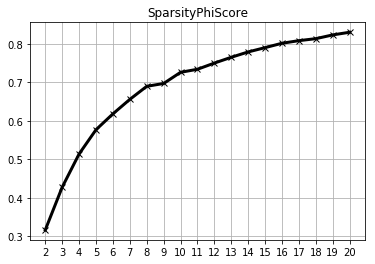

In [296]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [422]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [423]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 6, 0.8: 5}

Text(0.5, 1.0, 'SparsityThetaScore')

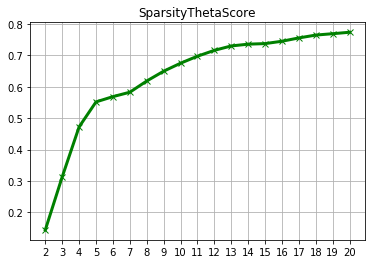

In [424]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [425]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.3, 0.4, 0.5, 0.6, 0.7]

In [427]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.3: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9}

Text(0.5, 1.0, 'PerplexityScore')

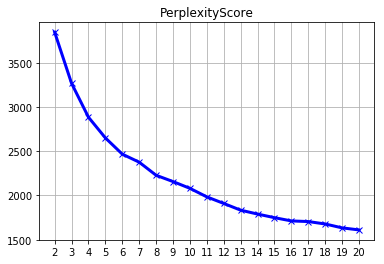

In [428]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [431]:
perplexity

[3844.85546875,
 3266.755126953125,
 2883.92431640625,
 2650.1103515625,
 2466.820556640625,
 2375.656494140625,
 2227.826416015625,
 2156.648193359375,
 2080.157470703125,
 1983.6279296875,
 1909.3548583984375,
 1833.3291015625,
 1789.39990234375,
 1748.635986328125,
 1711.8211669921875,
 1704.6588134765625,
 1677.3221435546875,
 1633.2545166015625,
 1610.190185546875]

### select the best model

In [434]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


### print top words for each topics

In [435]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['спартак' 'цска' 'зенит' 'локомотив' 'динамо' 'полузащитник' 'рубин'
 'премьерлига' 'москва' 'анжи']
topic_1: ['реал' 'челси' 'барселона' 'манчестер' 'англия' 'английский' 'испанский'
 'испания' 'полузащитник' 'юнайтед']
topic_2: ['группа' 'групповой' 'германия' 'отборочный' 'франция' 'этап' 'евро' 'чм'
 'португалия' 'бразилия']
topic_3: ['нба' 'цска' 'баскетболист' 'баскетбольный' 'очко' 'подбор' 'серия'
 'результативный' 'лосанджелес' 'евролига']
topic_4: ['очень' 'рассказать' 'подчеркнуть' 'хотеть' 'наш' 'добавить' 'считать'
 'интервью' 'мнение' 'приводить']
topic_5: ['стадион' 'украина' 'москва' 'проведение' 'город' 'динамо' 'украинский'
 'спортивный' 'санктпетербург' 'арен']
topic_6: ['полиция' 'суд' 'дело' 'находиться' 'бывший' 'обвинение' 'автомобиль'
 'человек' 'произойти' 'город']
topic_7: ['хоккей' 'хоккеист' 'хоккейный' 'кхл' 'нхл' 'шайба' 'металлург' 'ска'
 'авангард' 'динамо']
topic_8: ['болельщик' 'арбитр' 'фанат' 'стадион' 'судья' 'инцидент' 'произойти'
 'драка

### get topics-docs matrix

shape theta: (20, 60840)


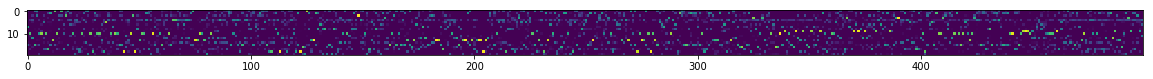

In [436]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [437]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
20000,0.000000,0.000000,0.000000,0.0,0.018165,0.000000,0.039194,0.249876,0.00000,0.0,0.0,0.000000,0.0,0.0,0.292646,0.352900,0.047219,0.000000,0.0,0.0
20001,0.522356,0.016158,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.013749,0.0,0.0,0.447737,0.000000,0.000000,0.000000,0.0,0.0
20002,0.062412,0.300723,0.091198,0.0,0.102581,0.000000,0.000000,0.000000,0.32776,0.0,0.0,0.000000,0.0,0.0,0.058050,0.057276,0.000000,0.000000,0.0,0.0
20003,0.782556,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.217444,0.000000,0.000000,0.0,0.0
20004,0.417641,0.000000,0.000000,0.0,0.000000,0.016686,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.565673,0.0,0.0


## DataViz

In [438]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.122868,0.000000,0.200359,...,0.307859,0.077717,0.000000,0.033593,0.239395,0.000000,0.0,0.000000,0.000000,0.01821
1,1,1999,10,0.018509,0.000000,0.262834,0.0,0.000000,0.330809,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.194672,0.0,0.000000,0.000000,0.00000
2,2,1999,10,0.000000,0.153630,0.000000,0.0,0.080671,0.045603,0.225730,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.494366,0.000000,0.00000
3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.155428,0.000000,0.000000,...,0.000000,0.043140,0.137149,0.000000,0.033424,0.000000,0.0,0.000000,0.551085,0.00000
4,4,1999,12,0.000000,0.109492,0.017353,0.0,0.000000,0.076010,0.000000,...,0.095460,0.000000,0.100906,0.000000,0.153172,0.000000,0.0,0.447607,0.000000,0.00000


In [439]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (227, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 9      0.051451  0.053678  0.020858  0.000000  0.387605  0.271702   
     10     0.018509  0.153630  0.262834  0.000000  0.358967  0.376411   
     11     0.000000  0.000000  0.041943  0.008126  0.192409  0.282047   
     12     0.000000  0.116069  0.017353  0.000000  0.000000  0.180712   
2000 1      0.139452  0.000000  0.044596  0.027264  0.657772  0.695795   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 9      1.343066  0.141417  0.878139  0.000000  0.000000  0.025867   
     10     0.426089  0.000000  0.193176  0.079775  0.307859  0.120857   
     11     1.184700  0.000000  0.221511  0.015529  0.031348  0.377125   
     12     0.000000  0.000000  0.000000  0.000000  0.095460  0.000000   
2000 1      0.714799  0.009442  1.227161  0.000000  0.000000  0.176262   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 9      0.249910  0.000000  0.022980  0.000000  0.000000  0.534287   
     10     0.137149  0.033593  0.272819  0.194672  0.000000  0.494366   
     11     0.907995  0.527579  0.000000  0.032994  0.065580  0.227409   
     12     0.850718  0.000000  0.171367  0.000000  0.083012  0.470070   
2000 1      0.432511  0.000000  0.018739  0.174023  0.144305  0.210975   

            topic_18  topic_19  
year month                      
1999 9      0.019041  0.000000  
     10     0.551085  0.018210  
     11     0.864289  0.019416  
     12     0.015239  0.000000  
2000 1      0.106825  0.220079

### straightforward matrix heatmap

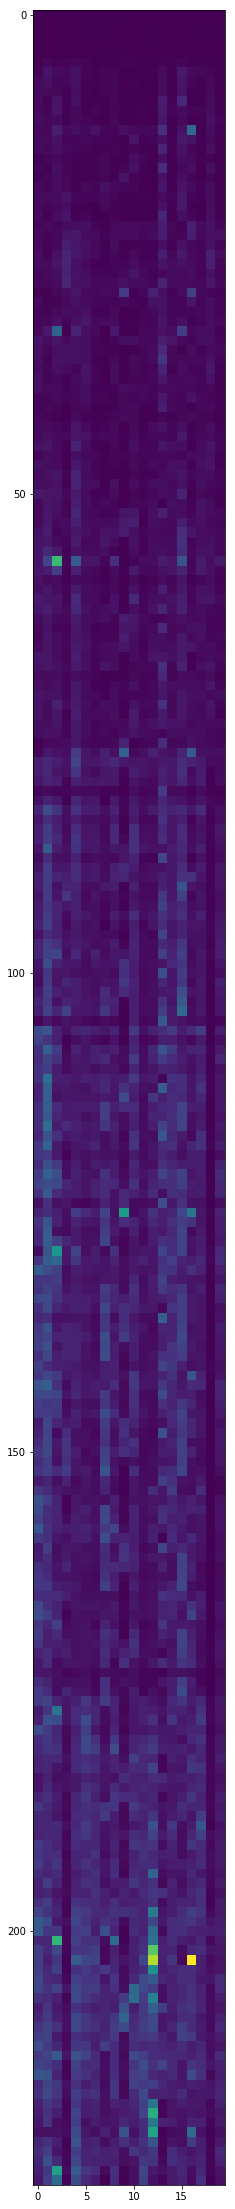

In [440]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [441]:
import pygal
from IPython.display import SVG, HTML

In [442]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [443]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [444]:
line_chart.render_to_file(f'data/visualization/{name_dataset}_pygal.svg')

## joypy

In [445]:
import joypy # !pip install joypy

In [446]:
print(joined.shape)
joined.head()

(60849, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.122868,0.000000,0.200359,...,0.307859,0.077717,0.000000,0.033593,0.239395,0.000000,0.0,0.000000,0.000000,0.01821
1,1,1999,10,0.018509,0.000000,0.262834,0.0,0.000000,0.330809,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.194672,0.0,0.000000,0.000000,0.00000
2,2,1999,10,0.000000,0.153630,0.000000,0.0,0.080671,0.045603,0.225730,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.494366,0.000000,0.00000
3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.155428,0.000000,0.000000,...,0.000000,0.043140,0.137149,0.000000,0.033424,0.000000,0.0,0.000000,0.551085,0.00000
4,4,1999,12,0.000000,0.109492,0.017353,0.0,0.000000,0.076010,0.000000,...,0.095460,0.000000,0.100906,0.000000,0.153172,0.000000,0.0,0.447607,0.000000,0.00000


In [447]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.000000,0.000000,0.000000,0.0,0.122868,0.000000,...,0.077717,0.000000,0.033593,0.239395,0.000000,0.0,0.000000,0.000000,0.01821,1999-10-01
1,1,1,1999,10,0.018509,0.000000,0.262834,0.0,0.000000,0.330809,...,0.000000,0.000000,0.000000,0.000000,0.194672,0.0,0.000000,0.000000,0.00000,1999-10-01
2,2,2,1999,10,0.000000,0.153630,0.000000,0.0,0.080671,0.045603,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.494366,0.000000,0.00000,1999-10-01
3,3,3,1999,10,0.000000,0.000000,0.000000,0.0,0.155428,0.000000,...,0.043140,0.137149,0.000000,0.033424,0.000000,0.0,0.000000,0.551085,0.00000,1999-10-01
4,4,4,1999,12,0.000000,0.109492,0.017353,0.0,0.000000,0.076010,...,0.000000,0.100906,0.000000,0.153172,0.000000,0.0,0.447607,0.000000,0.00000,1999-12-01


In [448]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1460376, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-12-01,index,4.0


In [449]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(1216980, 3)


topic_14    60849
topic_18    60849
topic_8     60849
topic_13    60849
topic_6     60849
topic_15    60849
topic_7     60849
topic_0     60849
topic_16    60849
topic_4     60849
topic_19    60849
topic_1     60849
topic_5     60849
topic_3     60849
topic_9     60849
topic_2     60849
topic_10    60849
topic_11    60849
topic_17    60849
topic_12    60849
Name: topic, dtype: int64

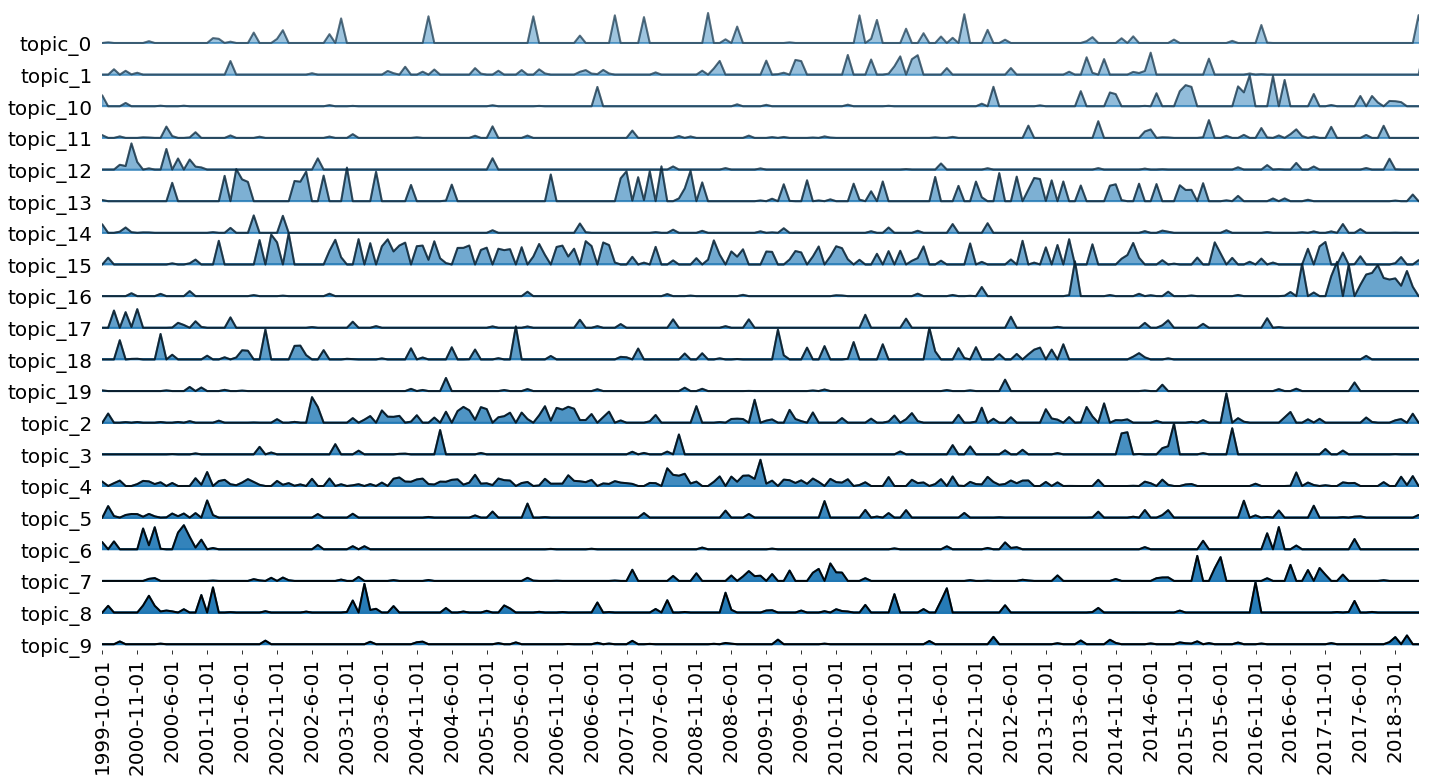

In [450]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [451]:
fig.savefig(f'data/visualization/{name_dataset}_joypy')